# トークトリアル 5

# 化合物クラスタリング

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Calvinna Caswara and Gizem Spriewald

## このトークトリアルの目的

類似の化合物は同じターゲット分子に結合し、類似の効果を示すかもしれません。この類似性質原則（similar property principle、SPP）に基づき、化合物類似度をつかって、クラスタリングによる化合物集団（chemical group）の構築を行うことができます。そのようなクラスタリングによって、より大きなスクリーニング化合物セットから、さらなる実験を行う対象となる化合物の多様性のあるセットを選ぶことができます。

## 学習の目標

このトークトリアルでは、以下についてさらに学びます：

* 化合物をグループ化する方法と、多様性のある化合物セットを選ぶ方法  
* クラスタリングアルゴリズム２つの簡潔な紹介  
* サンプル化合物セットへのButinaクラスタリングアルゴリズムの適用

### 理論

* クラスタリングとJarvis-Patrickアルゴリズムの紹介
* Butinaクラスタリングの詳細な説明
* 多様性の化合物の選択

### 実践

* Butinaクラスタリングと化合物選択の例

## レファレンス

* Butina, D. Unsupervised Data Base Clustering Based on Daylight’s Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Set. J. Chem. Inf. Comput. Sci. 1999.
* Leach, Andrew R., Gillet, Valerie J. An Introduction to Chemoinformatics. 2003
* Jarvis-Patrickクラスタリング: http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm
* TDT チュートリアル: https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb
* rdkitクラスタリングドキュメンテーション: http://rdkit.org/docs/Cookbook.html#clustering-molecules

_____________________________________________________________________________________________________________________


## 理論

### クラスタリングとJarvis-Patrickアルゴリズムの紹介

[クラスタリング（Clustering）](https://en.wikipedia.org/wiki/Cluster_analysis) は「ある一連のものをグループ化するタスクで、（クラスターと呼ばれる）同じグループに属するものが（ある基準において）、他のグループ（クラスター）に属するものと比較して、お互いにより似通っているようにグループ化するタスク」と定義することができます。

医薬品研究における化合物クラスタリングは化合物間の化学的、構造的類似度にしばしば基づいており、共通する特徴をもつグループをみつけたり、さらに解析を行うための多様性がある代表的な化合物セットをデザインするために行われます。

一般的な手順： 

* 近接するポイント間の類似度によってデータをクラスタリングすることに基づく手法  
* ケモインフォマティクスにおいて、化合物は化合物フィンガープリントでエンコードされ、類似度はタニモト類似度によって表現されることが多いです（**トークトリアル4**参照）
    * 念のため再確認：フィンガープリントはバイナリのベクトルで、各ビットはある特定の部分構造フラグメントが分子の中にあるか無いかを示します。
    * 類似度（あるいは距離）行列：　バイナリのフィンガープリントによって表現された分子のペアの類似度はタニモト係数を使って定量化されることがもっとも多く、これは共通する特徴（ビット）の数を評価する値です。
    * タニモト係数の値の範囲は０（類似性なし）から１（類似度が高い）となっています。

利用可能なクラスタリングアルゴリズムはたくさんありますが、中でも[Jarvis-Patrickクラスタリング](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm) は医薬品の分野において最も広く使われているアルゴリズムの一つです。

Jarvis-Patrickクラスタリングアルゴリズムは２つのパラメーター、KとK<sub>min</sub>で定義されています：
* 各分子のK最近傍のセットを計算
* ２つの化合物が次の場合、同じクラスターに含める
    * 最近傍のリストにお互い含まれている場合
    * K最近傍のうち少なくともK<sub>min</sub>を共通に持つ場合
    
Jarvis-Patrickクラスタリングアルゴリズムは決定的アルゴリズムで、巨大な化合物セットを数時間のうちに処理することができます。しかしながら、この手法の悪い側面として、大きく不均質なクラスタを生み出す傾向があります（Butinaクラスタリングの参考文献を参照）。

他のクラスタリングアルゴリズムについて知りたければ [scikit-learn clustering module](http://scikit-learn.org/stable/modules/clustering.html)　を参照してください。

### Butinaクラスタリングの詳細な説明

Butinaクラスタリング（[*J. Chem. Inf. Model.*(1999), 39(4), 747](https://pubs.acs.org/doi/abs/10.1021/ci9803381)）はより小さいが均質なクラスターを見つけるために開発されました。（少なくとも）クラスターの中心が、クラスター内の他の全ての分子と、与えられた閾値以上に類似していること、を前提条件とします。

このクラスタリングアプローチには鍵となるステップがあります（下のフローチャート参照してください）：

#### 1. データの準備と化合物エンコーディング
* 化合物類似性を見つけるために、入力データの化合物（例　SMILESとしてあたえられたもの）は化合物フィンガープリントとしてエンコードされます。例えば、RDK5フィンガープリントは、よく知られている[Daylight Fingerprint](/http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)（のオリジナル文献で使われていたもの）に似たサブグラフに基づく（subgraph-based）フィンガープリントです。

#### 2. タニモト類似度（あるいは距離）行列
* ２つのフィンガープリント間の類似度はタニモト係数を使って計算します
* 全ての可能な分子/フィンガープリントのペア間のタニモト類似度を要素とする行列です（　n x n 類似度行列、n=化合物数、上三角行列のみが使われます）
* 同様に、距離行列が計算できます（1 - 類似度）

#### 3. 化合物クラスタリング：中心（centroids）と排除球（exclusion spheres） 

注：化合物は次の場合に同じクラスターに含められます。（距離行列を使用する場合）クラスターのセントロイドからの最長距離が特定のカットオフ値以下の時、あるいは、（類似度行列を使用する場合）最小の類似度が特定のカットオフ値以上のときです。

* **潜在的なクラスター中心の発見**
    * クラスター中心は、与えられたクラスターの中で最も近傍化合物の数が多い分子です。
    * 近傍化合物の割り当て（Annotate neighbors）：各分子について、与えられた閾値以下のタニモト距離に含まれる全ての分子の数を数えます。
    * 化合物を近傍化合物の数によって降順に並べ替え、クラスター中心となりうるもの（即ち、近傍の数が最大となる化合物）をファイルの一番上に置くようにします。

* **排除球（exclusion shpheres）に基づくクラスタリング**
    * 並べ替えたリスト内の最初の分子（中心、centroid）から始めます。
        * クラスタリングに使われたカットオフ値以上のタニモトインデックスをもつ全ての化合物をクラスターのメンバーとします（類似度の場合）
            * 考慮しているクラスターのメンバーとなった各化合物にフラグをたて、以降の比較の対象から取り除きます。したがって、フラグがたてたれた化合物は他のクラスターの中心やメンバーとなることはできません。この手順は新しく作成したクラスターの周りに排除球を置くようなものです。
            * リストの最初の化合物について全ての近傍化合物がみつかったら、リストトップの最初に利用可能な（即ちフラグが立っていない）化合物を新しいクラスター中心とします。
        * リストのフラグの立っていない全ての化合物について、上から順に同じ手順を繰り返していきます。
    * クラスタリング手順の最後までフラグの立てられなかった化合物はシングルトン（singleton）となります。
        * シングルトンとして割り当てられた化合物の中には、指定したタニモト類似度インデックスで近傍となる化合物をもつものありえますが、これらの近傍化合物は、クラスター中心に基づく枠組みによってすでに排除球に含められていることに注意してください。

In [11]:
from IPython.display import IFrame
IFrame('./images/butina_full.pdf', width=600, height=300)

*Figure 1:* Butinaクラスタリングアルゴリズムの理論的な例（Calvinna Caswaraによる）

### 多様な化合物の選択

代表的な化合物セットを見つけるという考え方が、医薬品業界ではしばしば使われます。

* 例えば、バーチャルスクリーニングキャンペーンを行なったものの、リソースが非常に限られており、確認のためのアッセイ実験で評価可能な化合物数が少ないとしましょう。
* このスクリーニングから得られる情報を最大限のものとするために、多様性のある化合物セットを選びたいと思います。そのためには、活性を有する可能性がある化合物のリストの中で、各ケミカルシリーズを代表する一つを選択します。

別のシナリオとしては、構造活性相関、即ち化合物の小さな構造変化がin vitro活性にどう影響を与えるか？、について情報を得るために一連の化合物を選択する、というシナリオが考えられます。

## 実践

### Butinaクラスタリングアルゴリズムの使用例
[S. Riniker と G. LandrumによるTDT tutorial notebook](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb)の例にしたがって適用してみます。

#### 1. データの読み込みとフィンガープリントの計算
ここではデータの準備とフィンガープリントの計算を行います。

In [12]:
# パッケージのimport
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [13]:
# データを読み込んで眺める
# トークトリアル２で取り出したフィルタリング済みのデータ
compound_df= pd.read_csv('../data/T2/EGFR_compounds_lipinski.csv',sep=";", index_col=0)
print('data frame shape:',compound_df.shape)
compound_df.head()

data frame shape: (4523, 10)


,molecule_chembl_id,units,IC50,smiles,pIC50,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL63786,nM,0.003,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,yes
1,CHEMBL53711,nM,0.006,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,yes
2,CHEMBL35820,nM,0.006,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,yes
3,CHEMBL53753,nM,0.008,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,yes
4,CHEMBL66031,nM,0.008,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,yes


In [14]:
# SMILESから化合物を作成し、配列に格納
mols = []
for i in compound_df.index:
    chemblId = compound_df['molecule_chembl_id'][i]
    smiles = compound_df['smiles'][i]
    mols.append((Chem.MolFromSmiles(smiles), chemblId))
mols[0:5]

[(<rdkit.Chem.rdchem.Mol at 0x1037674e0>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x103767bc0>, 'CHEMBL53711'),
 (<rdkit.Chem.rdchem.Mol at 0x103767df0>, 'CHEMBL35820'),
 (<rdkit.Chem.rdchem.Mol at 0x103767da0>, 'CHEMBL53753'),
 (<rdkit.Chem.rdchem.Mol at 0x103767b70>, 'CHEMBL66031')]

In [15]:
# 全化合物についてフィンガープリントを作成
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in mols]

# 化合物/フィンガープリントは幾つあるでしょうか？
print('Number of compounds converted:',len(fingerprints))
print('Fingerprint length per compound:',len(fingerprints[0]))

Number of compounds converted: 4523
Fingerprint length per compound: 2048


#### 2.  タニモト類似度と距離行列
フィンガープリントが生成できたので、次の段階に進みます。クラスター中心となる可能性があるものの同定です。このために、タニモト類似度と距離行列を計算する関数を定義します。

In [16]:
# フィンガープリントのリストのための距離行列を計算
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # 距離行列が必要なので、類似度行列の全要素について1-xを計算
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

 [RDKitクックブック：分子のクラスタリング](http://rdkit.org/docs/Cookbook.html#clustering-molecules)も参照してください。

In [17]:
# 例：２つのフィンガープリントの類似度を一つ計算
sim = DataStructs.TanimotoSimilarity(fingerprints[0],fingerprints[1])
print ('Tanimoto similarity: %4.2f, distance: %4.2f' %(sim,1-sim))

Tanimoto similarity: 0.68, distance: 0.32


In [18]:
# 例：距離行列を計算（距離 = 1-類似度）
Tanimoto_distance_matrix(fingerprints)[0:5]

[0.31818181818181823,
 0.31474103585657376,
 0.430976430976431,
 0.26991150442477874,
 0.07111111111111112]

In [19]:
# 追記：　行列ではなくリストのように見えます。 
# しかし、リスト形式の上三角行列です。
n = len(fingerprints)

# n*(n-1)/2　によって三角行列の要素数を計算します。
elem_triangular_matr = (n*(n-1))/2
print(int(elem_triangular_matr), len(Tanimoto_distance_matrix(fingerprints)))

10226503 10226503


#### 3. 化合物クラスタリング：中心（centroids）と排除球（exclusion spheres）
ここでは、化合物のクラスター化を行い結果を眺めます。

クラスタリング関数の定義

In [20]:
# 入力：フィンガープリントとクラスタリングの閾値
def ClusterFps(fps,cutoff=0.2):
    # タニモト距離行列の計算
    distance_matr = Tanimoto_distance_matrix(fps)
    # Butinaアルゴリズムの実装を使ってデータをクラスタリング:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

フィンガープリントの類似度に基づき化合物をクラスター化

In [21]:
# データセットのためのクラスタリング手順を実行
clusters = ClusterFps(fingerprints,cutoff=0.3)

# クラスターの数とサイズについて短いレポートを表示
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  681
# clusters with only 1 compound:  305
# clusters with >5 compounds:  157
# clusters with >25 compounds:  33
# clusters with >100 compounds:  4


**訳注(04/2020)**

ここで実行しているRDKitの[Butinaモジュール](https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html)の戻り値はクラスターの情報を含むタプルのタプルです。

( (cluster1_elem1, cluster1_elem2, …), (cluster2_elem1, cluster2_elem2, …), …)

という形式で、タプル内タプルの最初の`clusterX_elem1`は各クラスターXのcentroidとなっています。  
上記では`len()`でクラスターのサイズを取得しています。

**訳注ここまで**

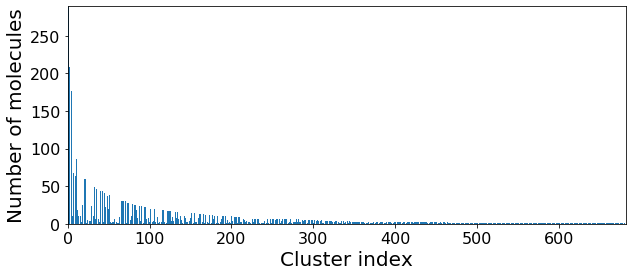

In [22]:
# クラスターの大きさをプロット
fig = plt.figure(1, figsize=(10, 4))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('Number of molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.show()

#### 合理的なカットオフ値を選ぶにはどうすればよいか？

クラスタリングの結果はユーザーの選んだ閾値に依存するので、カットオフ値の選択についてより詳細に見てみたいと思います。

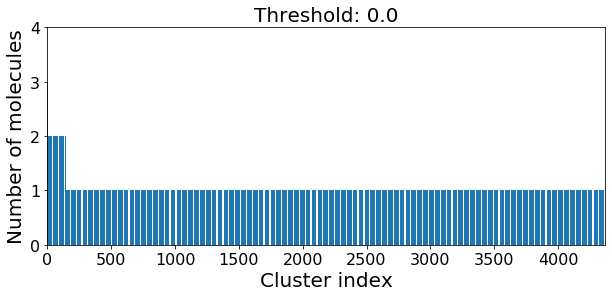

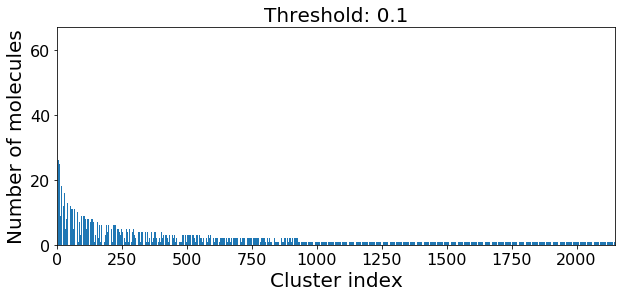

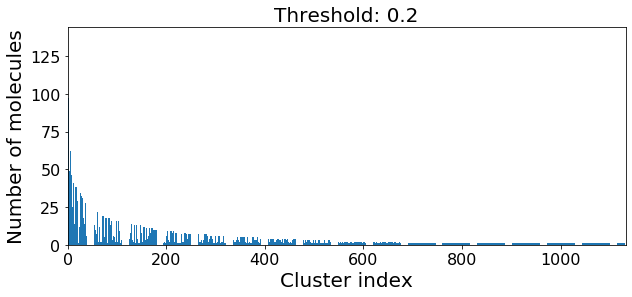

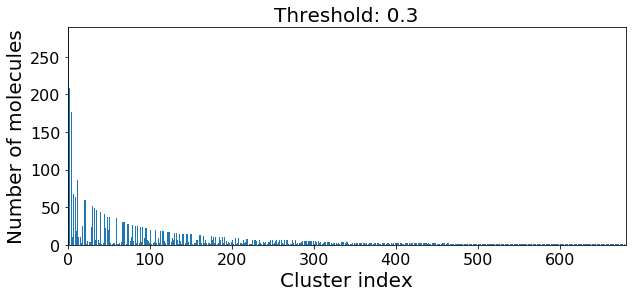

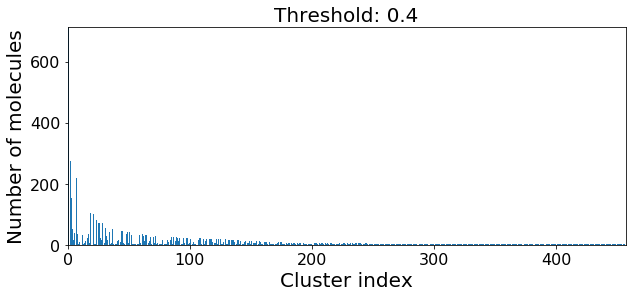

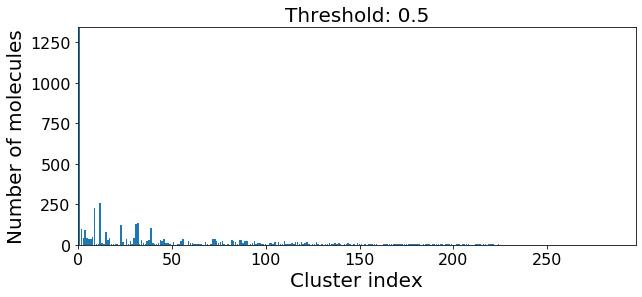

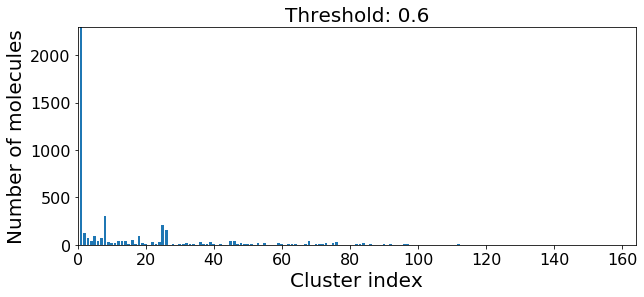

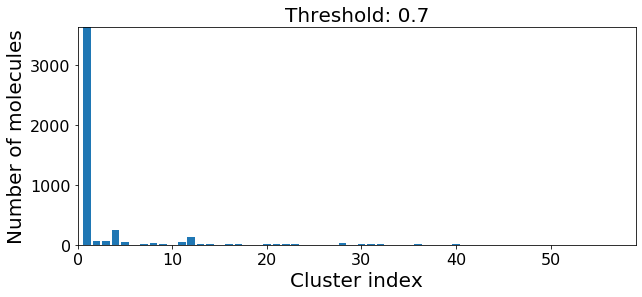

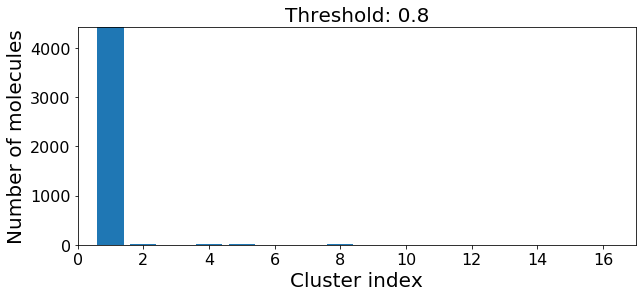

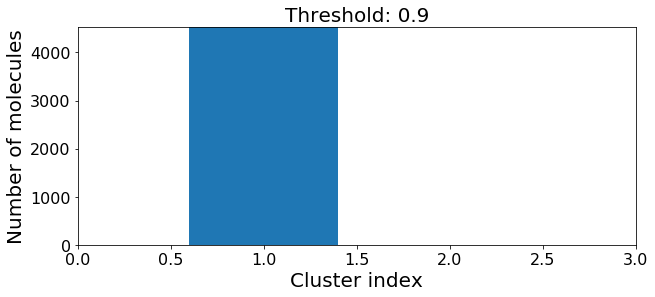

In [23]:
for i in numpy.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fingerprints,cutoff=i)
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %i), fontsize=20)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

結果を見ると、閾値（距離のカットオフ）が高いほど、より多くの化合物が類似しているとみなされ、したがってより少ないクラスター数にクラスタリングされます。閾値が低くなると、より多数の小さなクラスターとシングルトン（singleton）が現れます。

* 距離のカットオフ値がより小さくなるほど、一つのクラスターに所属する化合物は互いにより類似していることが求められます。

上のプロットをもとにて、私たちは距離の閾値0.2を選択しました。シングルトンの数が多くなく、クラスターのサイズが大き過ぎていませんが、分布は滑らかになっています。

Number of clusters 1132 from 4523 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 143
Similarity between two random points in same cluster 0.92
Similarity between two random points in different cluster 0.30


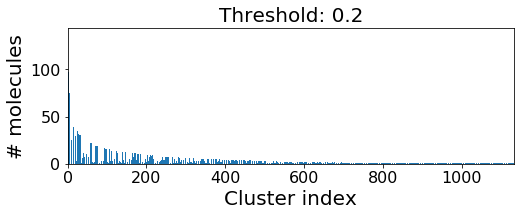

In [24]:
dist_co = 0.2
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# クラスターのサイズをプロットー保存
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("../data/T5/cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(mols), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

### クラスターの可視化

#### 最大のクラスターからの化合物例10個

最初の最もサイズの大きいクラスターから、初めの１０化合物をより詳細に見てみましょう。

Ten molecules from largest cluster:


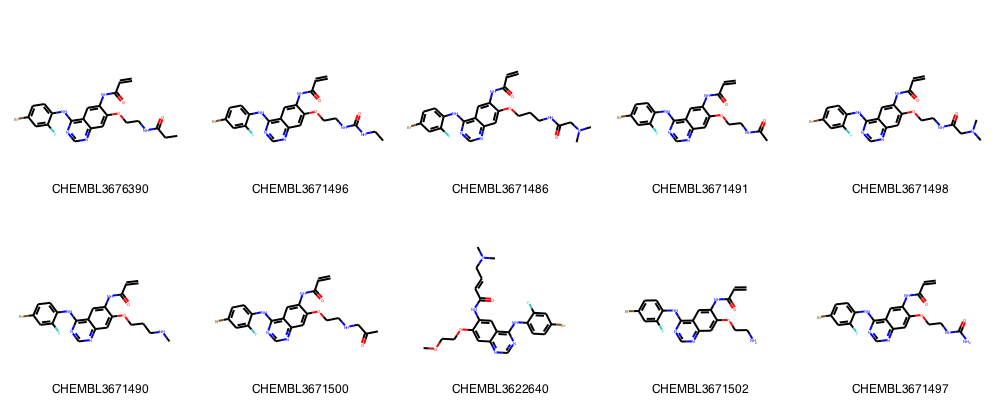

In [25]:
print ('Ten molecules from largest cluster:')
# 化合物描画
Draw.MolsToGridImage([mols[i][0] for i in clusters[0][:10]], 
                     legends=[mols[i][1] for i in clusters[0][:10]], 
                     molsPerRow=5)

In [26]:
# トークトリアル9でMCS解析を行うため最大のサイズのクラスターの化合物を保存
# 訳注:上記はトークトリアル6の記載ミスか？

w = Chem.SDWriter('../data/T5/molSet_largestCluster.sdf')

# データの準備
tmp_mols=[]
for i in clusters[0]:
    tmp = mols[i][0]
    tmp.SetProp("_Name",mols[i][1])
    tmp_mols.append(tmp)  

# データの書き出し
for m in tmp_mols: w.write(m)

#### 2番目に大きいクラスターからの化合物例10個

Ten molecules from second largest cluster:


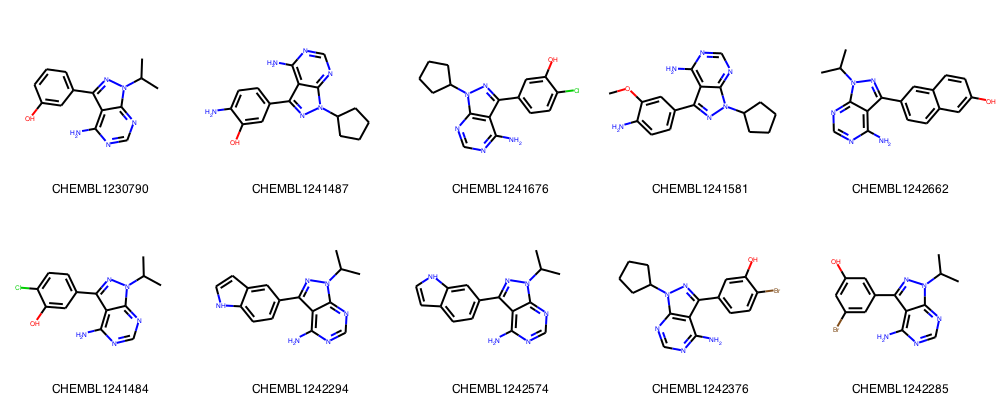

In [27]:
print ('Ten molecules from second largest cluster:')
# 化合物の描画
Draw.MolsToGridImage([mols[i][0] for i in clusters[1][:10]], 
                     legends=[mols[i][1] for i in clusters[1][:10]], 
                     molsPerRow=5)

それぞれのクラスターの最初の１０化合物は実際にお互いに類似しており、多くが共通の骨格を共有しています（視覚的に判断する限り）。

化合物セットの最大共通部分構造（maximum common substructure、MCS）を計算する方法について、もっと知りたければ**トークトリアル6**を参照してください。


#### 最初の10クラスターからの例

比較のため、最初の10クラスターのクラスター中心を見てみます。

Ten molecules from first 10 clusters:


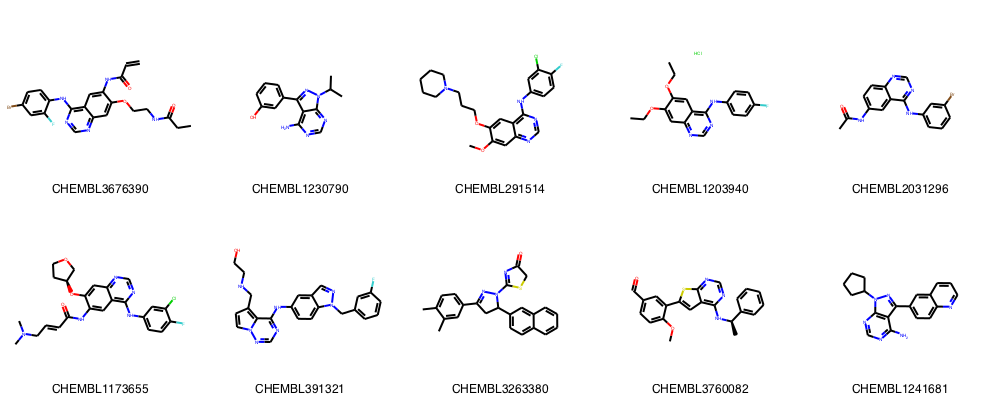

In [28]:
print ('Ten molecules from first 10 clusters:')
# 化合物を描画
Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(10)], 
                     legends=[mols[clusters[i][0]][1] for i in range(10)], 
                     molsPerRow=5)

最初の３つクラスターから取り出したクラスター中心をSVGファイルとして保存。

In [29]:
# イメージを生成
img = Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(0,3)],
                     legends=["Cluster "+str(i) for i in range(1,4)],
                     subImgSize=(200,200), useSVG=True)

# SVGデータを取得
molsvg = img.data

# 不透明な背景を透明に置き換え、フォントサイズを設定
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "20px");

# 変換したSVGデータをファイルに保存
f = open("../data/T5/cluster_representatives.svg", "w")
f.write(molsvg)
f.close()

まだいくらか類似性が残っているのが見てとれますが、明らかに、異なるクラスターの中心同士は、一つのクラスター内の化合物同士と比較して、類似性が低くなっています。

#### クラスター内タニモト類似度

クラスター内のタニモト類似度をみてみることもできます。

In [30]:
# 各クラスターのフィンガープリントの全てのペアについてタニモト類似度を計算する関数
def IntraTanimoto(fps_clusters):
    intra_similarity =[]
    # クラスターごとの内部類似度を計算
    for k in range(0,len(fps_clusters)):
        # 類似度行列（１ー距離）に変換されたタニモト距離行列の関数
        intra_similarity.append([1-x for x in Tanimoto_distance_matrix(fps_clusters[k])])
    return intra_similarity    

In [31]:
# 最初の10個のクラスターについてフィンガープリントを再計算
mol_fps_per_cluster=[]
for c in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(mols[i][0]) for i in c])
# クラスター内類似度を計算 
intra_sim = IntraTanimoto(mol_fps_per_cluster)

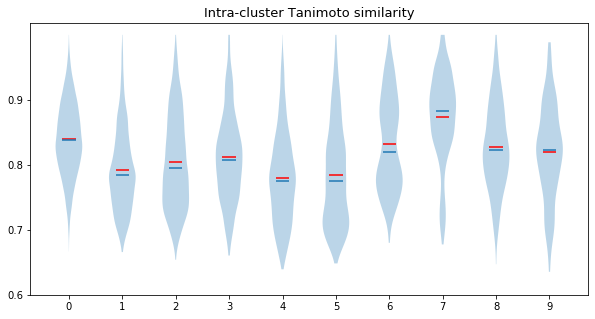

In [32]:
# クラスター内類似度とともにバイオリンプロット
pos = list(range(10))
labels = pos
plt.figure(1, figsize=(10, 5))
ax = plt.subplot(111)
r = plt.violinplot(intra_sim, pos, showmeans=True, showmedians=True, showextrema=False)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0.6, 1., 0.1))
ax.set_title('Intra-cluster Tanimoto similarity', fontsize=13)
r['cmeans'].set_color('red')
# 平均=赤色, 中央値=青色

### 化合物選択

以下では、**多様性のある**サブセットとして**最大 1000化合物**の最終リストを取り出します。

このため、最大サイズのクラスターから始めて最大1000化合物を取り出すまで、各クラスターのクラスター中心（即ち、各クラスターの最初の分子）をとりだして、各クラスターのクラスター中心と最も似ている10化合物（あるいは、クラスター化合物が10以下のときは50%の化合物）を選びます。これにより、各クラスターの代表が得られます。

この化合物選択の目的は、確認用アッセイ実験に提案するためのより小さな化合物セットの多様性を確保することです。

選択の手順は[S. Riniker　と G. LandrumによるTDT tutorial notebook](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb)からとりました。ノートブックで述べられているように、このアプローチの背景にあるアイデアは、確認アッセイ実験の結果からSARを取得しつつ（より大きなクラスターの非常に類似した化合物群を保ちつつ）、多様性を確保する（各クラスターの代表を組み入れる）ことです。

クラスター中心を取得します。

In [33]:
# 各クラスターのクラスター中心を取得（各クラスターの最初の化合物）
clus_center = [mols[c[0]] for c in clusters]
# クラスター中心/クラスターはいくつあるか？
print('Number of cluster centers: ', len(clus_center))

Number of cluster centers:  1132


サイズによってクラスターを並べ替え、類似度によって各クラスターの化合物を並べ換える。

In [34]:
# クラスター中心に対する類似度に基づいてクラスター内の化合物を並べ替え、
# サイズに基づきクラスターを並べ替えます。
clusters_sort = []
for c in clusters:
    if len(c) < 2: continue # シングルトン
    else:
        # 各クラスター要素についてフィンガープリントを計算
        fps_clust = [rdkit_gen.GetFingerprint(mols[i][0]) for i in c]
        # クラスター中心に対する全クラスターメンバーの類似度
        simils = DataStructs.BulkTanimotoSimilarity(fps_clust[0],fps_clust[1:])
        # （中心は除いて！）類似度に化合物のインデックスを付与する
        simils = [(s,index) for s,index in zip(simils, c[1:])]
        # 類似度によって降順に並べ替え
        simils.sort(reverse=True)
        # クラスターのサイズと化合物インデックスをclusters_sortに保存
        clusters_sort.append((len(simils), [i for s,i in simils]))
        # クラスターサイズによって降順にソート
        clusters_sort.sort(reverse=True)

最大1000化合物を取り出す。

In [38]:
# 選んだ分子を数える、はじめにクラスター中心を取り出す
sel_molecules = clus_center.copy()
# 最大のクラスターからはじめて、各クラスターの10化合物（あるいは 最大の50%)を取り出す
index = 0
diff = 1000 - len(sel_molecules)
while diff > 0  and index < len(clusters_sort):
    # 並べ替えたクラスターのインデックスを取得
    tmp_cluster = clusters_sort[index][1]
    # 最初のクラスターが10以上の大きさの時、ちょうど10化合物を取り出す
    if clusters_sort[index][0] > 10:
        num_compounds = 10
    # 10より小さいなら、化合物の半分をとる
    else:
        num_compounds = int(0.5*len(c))+1
    if num_compounds > diff: 
        num_compounds = diff
    # picked_fps と名付けたリストのリストに取り出した分子と構造を書き込む
    # 訳注: 上記リストの名称 picked_fpsはsel_moleculesの記載ミスか？
    sel_molecules += [mols[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    diff = 1000 - len(sel_molecules)
print('# Selected molecules: '+str(len(sel_molecules)))

# Selected molecules: 1132


この多様性のある化合物のセットは実験による評価に用いることができます。

**訳注(2020/04)**

上記で選択された化合物は**1132**個となっており、意図した最大1000個とはなっていません。オリジナルのノートブックと異なり、現在（2020年04月）の取得データをもとにすると、クラスター数が**1132**個となり、クラスター数の時点で1000個を超えています（オリジナルは**988**個）。ですので、上記コードのクラスター中心を取り出した`sel_molecules`が1000以上（`diff <0`） となり、`while`条件文以降が実行されないという結果となっています。以下、コードが正しく機能するか確認のため、取り出す化合物の最大数を1200個にして実行して見ます。

In [39]:
sel_molecules2 = clus_center.copy()
index = 0
diff = 1200 - len(sel_molecules2)
while diff > 0  and index < len(clusters_sort):
    tmp_cluster = clusters_sort[index][1]
    if clusters_sort[index][0] > 10:
        num_compounds = 10
    else:
        num_compounds = int(0.5*len(c))+1
    if num_compounds > diff: 
        num_compounds = diff
    sel_molecules2 += [mols[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    diff = 1200 - len(sel_molecules2)
print('# Selected molecules: '+str(len(sel_molecules2)))

# Selected molecules: 1200


指定した1200個の化合物を取り出すことができました。他の検証方法としてはクラスタリングの閾値を0.2よりも大きくしてクラスター数を1000個以下とすることがあげられると思います。

**訳注ここまで**

### (追加情報：実行時間)

トークトリアルの終わりに、データセットのサイズが変わった時に、Butinaクラスタリングの実行時間がどのように変わるかみてみましょう。

In [40]:
# 古いデータセットを再利用
sampled_mols = mols.copy()

より大きなデータセットを試してみることもできますが、10000以上のデータポイントの時点で非常に大きなメモリと時間がかかりはじめます（これがここで止めた理由です。）


In [41]:
# 時間を図るためのヘルパー関数
def MeasureRuntime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in sampled_mols]

    # データセットでクラスタリングを実行
    sampled_clusters = ClusterFps(sampled_fingerprints,cutoff=0.3)
    return(time.time() - start_time)

In [42]:
dsize=[100, 500, 1000, 2000, 4000, 6000, 8000, 10000] 
runtimes=[]
# 置き換えありで、ランダムにサンプルをとる
for s in dsize:
    tmp_set = [sampled_mols[i] for i in sorted(numpy.random.choice(range(len(sampled_mols)), size=s))]
    tmp_t= MeasureRuntime(tmp_set)
    print('Dataset size %d, time %4.2f seconds' %(s, tmp_t))
    runtimes.append(tmp_t)

Dataset size 100, time 0.10 seconds
Dataset size 500, time 0.49 seconds
Dataset size 1000, time 0.99 seconds
Dataset size 2000, time 2.31 seconds
Dataset size 4000, time 5.96 seconds
Dataset size 6000, time 11.26 seconds
Dataset size 8000, time 18.28 seconds
Dataset size 10000, time 25.67 seconds


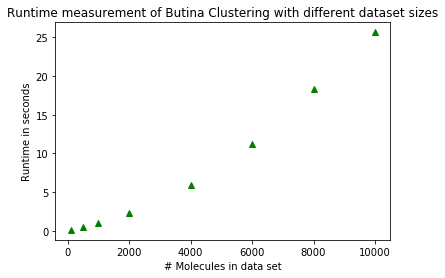

In [43]:
plt.plot(dsize, runtimes, 'g^')
plt.title('Runtime measurement of Butina Clustering with different dataset sizes')
plt.xlabel('# Molecules in data set')
plt.ylabel('Runtime in seconds')
plt.show()

## クイズ
* 化合物のクラスタリングはなぜ重要なのでしょうか？
* 化合物セットのクラスタリングにどのアルゴリズムを使うことができますか？また、アルゴリズムの背景になる一般的な考え方はどのようなものでしょうか？
* 他のクラスタリングアルゴリズムを知っていますか？